# Kaggle の Kickstaeter 問題
- かがわAIゼミナール基礎編の後半の課題として取り組む
- KaggleのKickstarter Projectsの2018年データを利用 https://www.kaggle.com/kemical/kickstarter-projects/
- 大まかな方針として，nameの文字数，category, main_category, deadline, launched, country を説明変数とし，usd_pledged_realを線形モデルで推定．そして推定結果をusd_goal_realと比較することでプロジェクトの成否を判定した．
- 結果，59.138%の正答率が得られた．

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数


# データの読み込み
- データを読み込んだ
- 基本の情報，いくつかのデータ例，散布図行列を見た
    - 15の列があることが分かった
    - 378661個のデータがあることが分かった
    - "name"と"usd_pledged"に欠損値があることが分かった．
        - プロジェクト名の欠損値は少ないので省いて問題なさそう
        - usd_pledgedも欠損数は1%程度なので省いても問題ない．他の項目から推定できるかもしれない．
        - usd_pledgedは予想には使えないデータなのであまり問題はない可能性が高い．（ただ，ここを線形回帰で予想して，goalと比較したら成否を判定できる意味では利用価値がないとは言えない）

In [137]:
# データの読み込み
df = pd.read_csv("./ks-projects-201801.csv")

display(df.info())
print(df.isnull().sum())
display(df.describe())
display(df.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


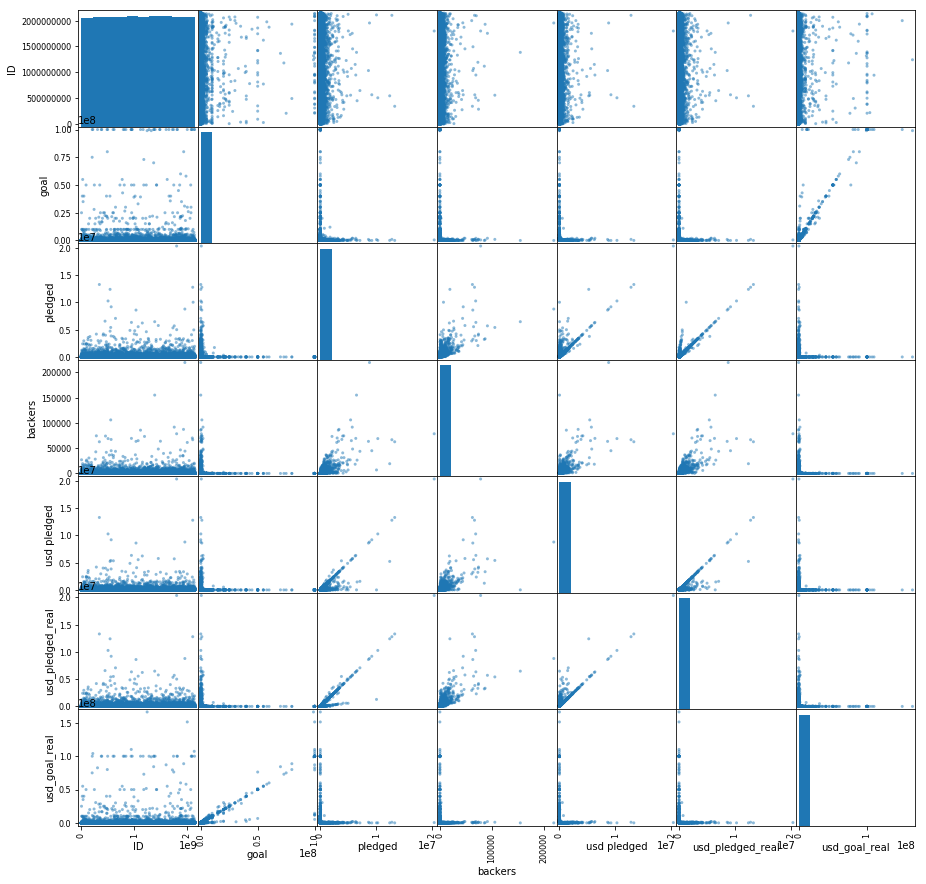

In [138]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

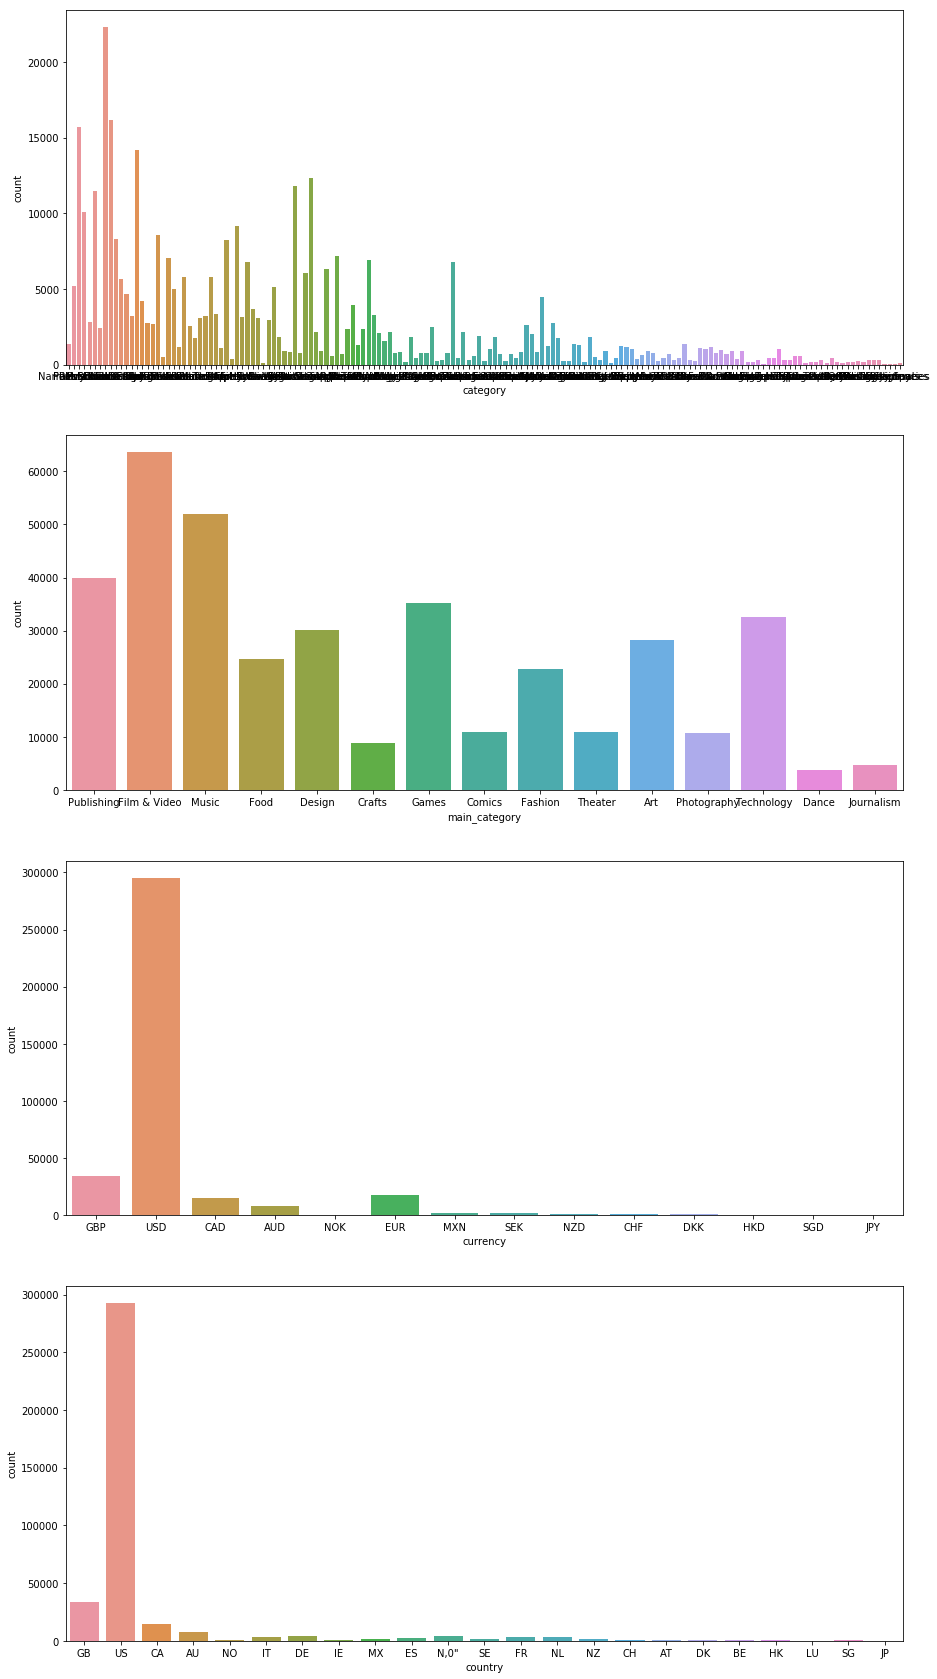

In [140]:
fig,ax = plt.subplots(4,1,figsize=(15,30))
sns.countplot(df.category,ax=ax[0])
sns.countplot(df.main_category,ax=ax[1])
sns.countplot(df.currency,ax=ax[2])
sns.countplot(df.country,ax=ax[3])
plt.show()

# 作戦
- stateを推測する．
- 講座中に，successfulとfalse以外は省いて考えると良いとアドバイスがあったので従う．
- IDは使わない．
- usd_pledged_realを回帰で求めて，それをusd_goal_realと比較してstateを推測することとする．
    - 実際のstateの決まり方に従った形．
    - 私の業務ではロボットの制御をしたく，分類よりも回帰に興味があるため．

- usd_pledged と usd_pledged_real はデータ例を見るとほぼ同じ値で，散布図行列でも45度の分布したデータが多い．ただ2番目のデータ例ではusd_pledged_realの方が正しそうであることと，usd_pledgedは比較的欠損値が多いことと，usd_goal_realと同じAPIで通貨変化をしているのがusd_pledged_realであることから，usd_pledgedは利用しない．（どっちが正しいかはより詳しい検証が必要かもしれない．）
- 通貨はすべて米ドルでそろえた方が比較しやすいので，米ドルで考える．
    - このためgoal, pledgedは見ない（Fixer.io APIの変換がうまくいっているかの検証を後で行う余裕があれば，そのために使うかも．）．
    - currencyは地域を反映するのに使えるが，それはcountryでわかるので，currencyは使わない．
- 日付はそのままでは解析しにくいので変換する．
    - 日付のままでは扱いにくいので2000年1月0日からの経過日数で表現する．（kickstarterの設立は2009年）
    - 年を追うごとにkickstarterが盛り上がっている可能性もあるか？
    - deadline - launchedで「公開日から締め切りまでの日数」に変換して考えることも考えたが，線形な変換なので不要と判断した．
    

# 調査（Kickstarter本家サイトの利用者向け情報より）
- 「30日以下のプロジェクトは成功率が高い」（https://www.kickstarter.com/help/handbook/funding?ref=handbook_rewards）
- 一人当たりの平均的な支援額は25ドル（https://www.kickstarter.com/help/handbook/rewards?ref=handbook_story）



# 変数のまとめ

|目標変数|説明変数|
|:---|:---|
|usd_pledged_real|(length of) name<br>category<br>main_category<br>deadline<br>lanched<br>country<br>usd_goal_real|

|列名|列名の意味|説明変数に使えるか？|目標変数に指定|説明変数に指定|備考|
|:---:|:---:|:---:|:---:|:---:|:---:|
|ID|ID|o|x|x|-|
|name|プロジェクト名|o|x|o|とりあえず文字数を説明変数として利用|
|category|カテゴリー|o|x|-|とりあえず，カテゴリー毎に推定|
|main_category|メインカテゴリー|o|x|-|とりあえず，カテゴリー毎に推定|
|currency|プロジェクト通貨|o|x|x|countryと同様と考えた|
|deadline|締め切り|o|x|o|最古のlaunchedからの日数に変換|
|goal|目標額|o|x|x|usd_goal_realを利用|
|launched|公開日|o|x|o|launch時刻は今は捨てる|
|pledged|支援額|x|x|x|-|
|state|成否|x|(o)|x|分類問題の目標変数であるが，回帰問題として考える中では使わない|
|backers|支援者数|x|x|x|-|
|country|国|o|x|-|とりあえず国ごとに推定|
|usd_pledged|支援額(\$)|x|x|x|usd_pledged_realを使う|
|usd_pledged_real|支援額(\$)|x|o|x|回帰の目標変数とする|
|usd_goal_real|目標額(\$)|o|x|o|-|



# 前処理
- 使わない列を削除
- successfulとfalse以外のデータは捨てる
- nameに欠損値のあるデータはとりあえず捨てる
- nameを文字数に変換
- deadlineとlaunchedを2000年1月0日からの日数に変換
- ダミー変数化

In [141]:
# 使わない列を削除
df = df.drop(columns=["ID","currency","goal","pledged","backers","usd pledged"])


# successfulとfailed以外は除く
df = df[ (df["state"]=="successful") | (df["state"]=="failed") ]

# (name が)欠損しているデータを除く
df = df.dropna()

# nameを文字数データに変えて，元のname列を削除
df["name_len"] = df["name"].apply(len)
df = df.drop(columns="name")
    
# 日付を2000年1月0日からの経過日数に変換する関数を定義
# 面倒なのですべて1年は365日で，1月は30日として粗く変換
# 20yy-mm-dd を仮定
def date2days(s):
    y = int(s[2])*10 + int(s[3])
    m = int(s[5])*10 + int(s[6])
    d = int(s[8])*10 + int(s[9])
    days = y*365 + m*30 + d
    return days
# deadline
df["deadline_num"] = df["deadline"].apply(date2days)
df = df.drop(columns="deadline")
#launched
df["launched_num"] = df["launched"].apply(date2days)
df = df.drop(columns="launched")

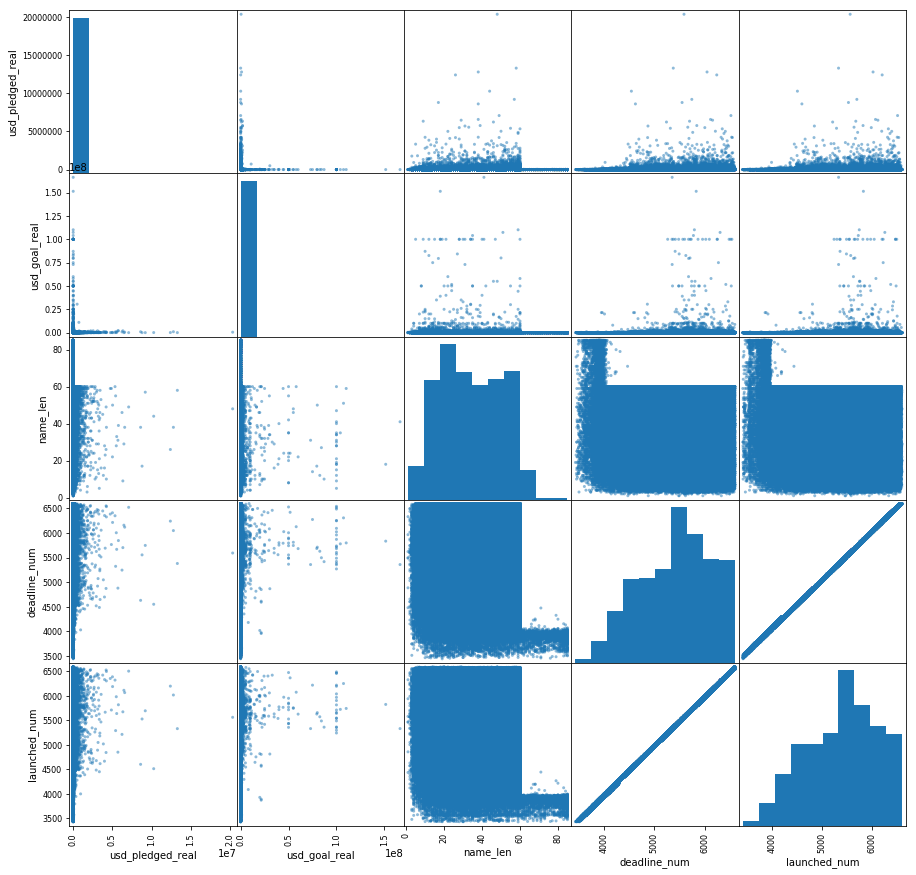

In [142]:
# deadlineやlaunchedも数値化したので，もう一度，散布図行列を見てみる．
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

残念ながら，usd_pledged_realと相関の強そうなものは見当たらない．

In [143]:
# ダミー変数化
df = pd.get_dummies(df, columns=["category","main_category","country"])

In [144]:
df.head()

,state,usd_pledged_real,usd_goal_real,name_len,deadline_num,launched_num,category_3D Printing,category_Academic,category_Accessories,category_Action,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,failed,0.0,1533.95,31,5784,5726,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,failed,2421.0,30000.00,45,6536,6477,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,failed,220.0,45000.00,14,4831,4787,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,failed,1.0,5000.00,49,4516,4487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,successful,52375.0,50000.00,20,5961,5926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# usd_pledged_realを推定する線形モデルの学習

In [145]:
# usd_pledged_realを推定する重回帰モデルを作成
y = df.usd_pledged_real.values
X = df.drop(['usd_pledged_real',"state"], axis=1).values

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数

# 値を予測
y_pred = model.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 9196711232.254
MAE = 13954.967
RMSE = 95899.485


# 推定したusd_pledged_realと与えられたデータusd_goal_realを比較して，成否を推定

In [147]:
# 回帰モデルの結果y_predとusd_goal_realを比較して成否を判定
y2_pred = y_pred - df.usd_goal_real.values
y2_pred = np.where( y2_pred>=0, True, False )


# 正解データをバイナリに加工
y2 = np.where( df.state.values=="successful", True, False )

In [148]:
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# 正答率を計算
accuracy =  accuracy_score(y2, y2_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y2, y2_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision[1]))
print('再現率（Recall） = {:.3%}'.format(recall[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y2, y2_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

正答率（Accuracy） = 59.138%
適合率（Precision） = 49.507%
再現率（Recall） = 58.941%
F1値（F1-score） = 53.814%


,予測 = failed,予測 = successful
正解 = failed,117189,80527
正解 = successful,55001,78955


# 結果
- 正答率・再現率は59%であるが，適合率は50%．あてずっぽうよりは少しだけ当たっている程度という印象である．
- usd_pledged_realの推定のMAEは14000ドル程度であり大きいようにも感じるが，正解データのSTDが90000ドル程度あるのでそう悪くないのか？